
=== Variante: RFM — features: ['recency_days', 'frequency', 'monetary'] ===


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


Saved -> outputs/kmeans_compare/RFM/bars_RFM_K3.png


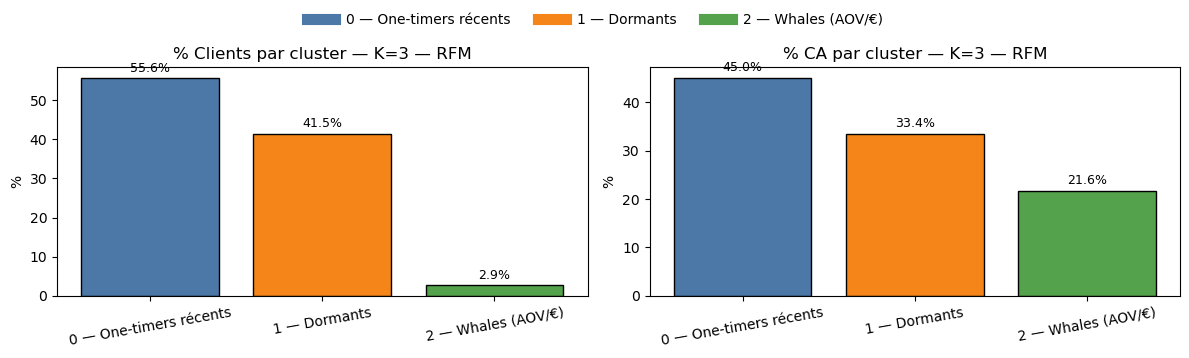

Saved -> outputs/kmeans_compare/RFM/radar_RFM_K3.png


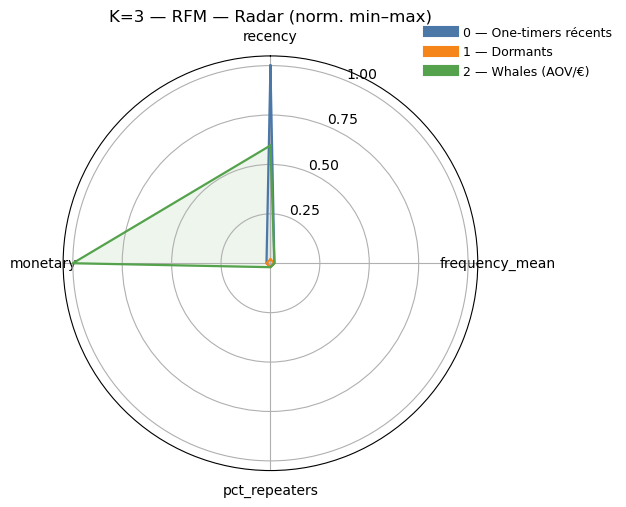

Saved -> outputs/kmeans_compare/RFM/bars_RFM_K4.png


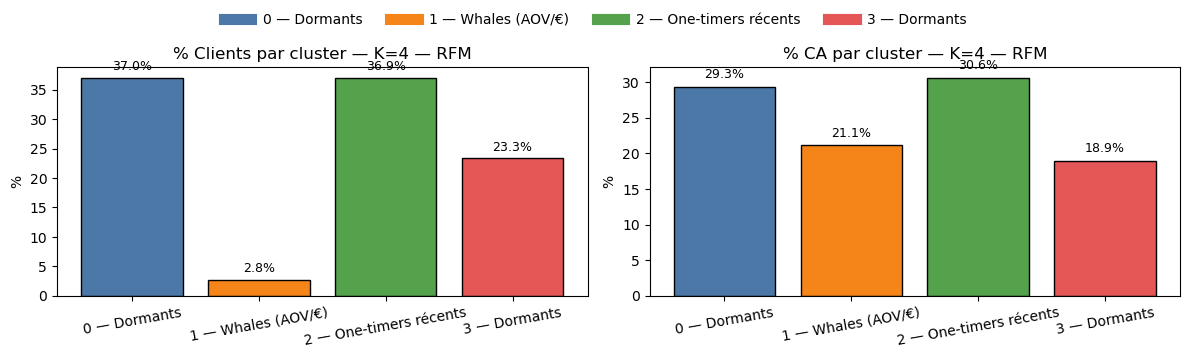

Saved -> outputs/kmeans_compare/RFM/radar_RFM_K4.png


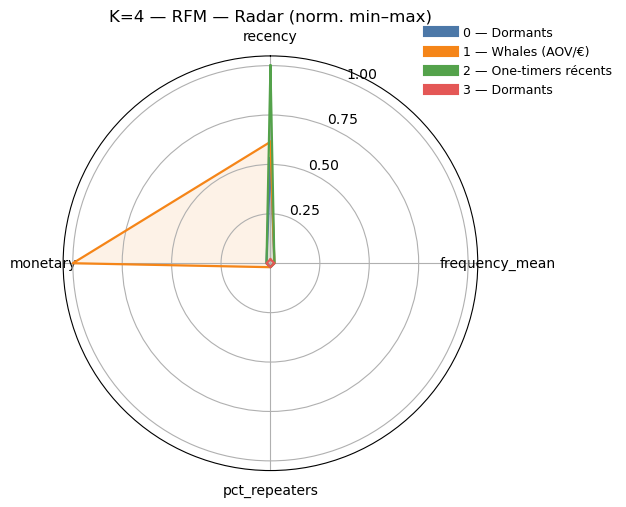

Saved -> outputs/kmeans_compare/RFM/bars_RFM_K5.png


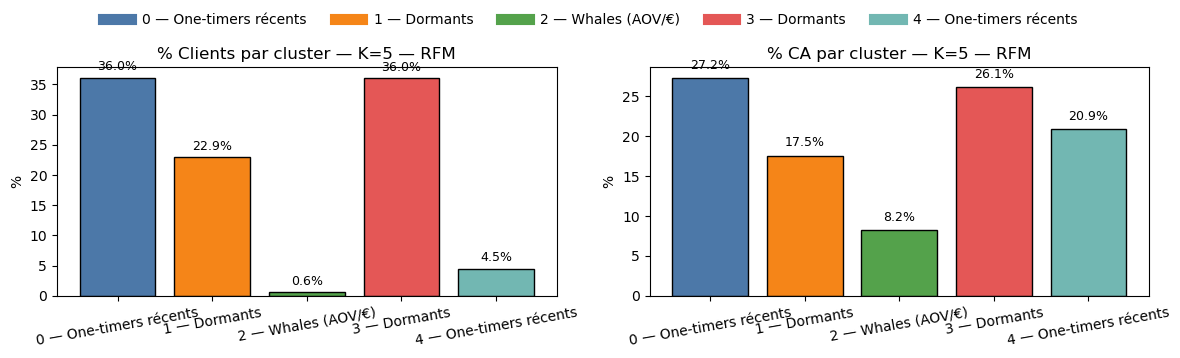

Saved -> outputs/kmeans_compare/RFM/radar_RFM_K5.png


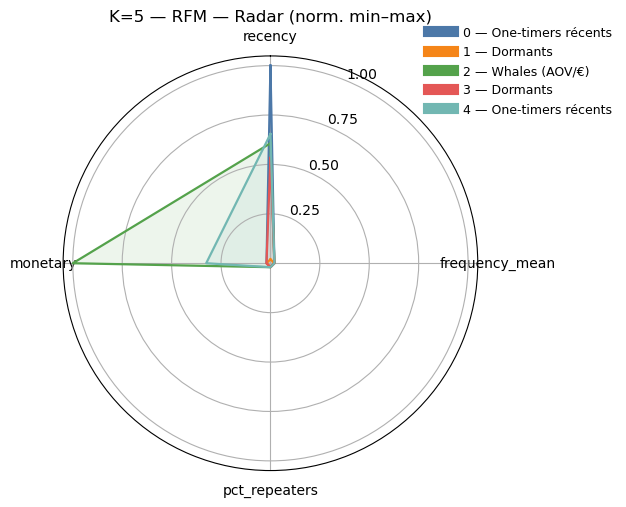


=== Variante: RFM+review — features: ['recency_days', 'frequency', 'monetary', 'avg_review_score'] ===
Saved -> outputs/kmeans_compare/RFM_review/bars_RFM+review_K3.png


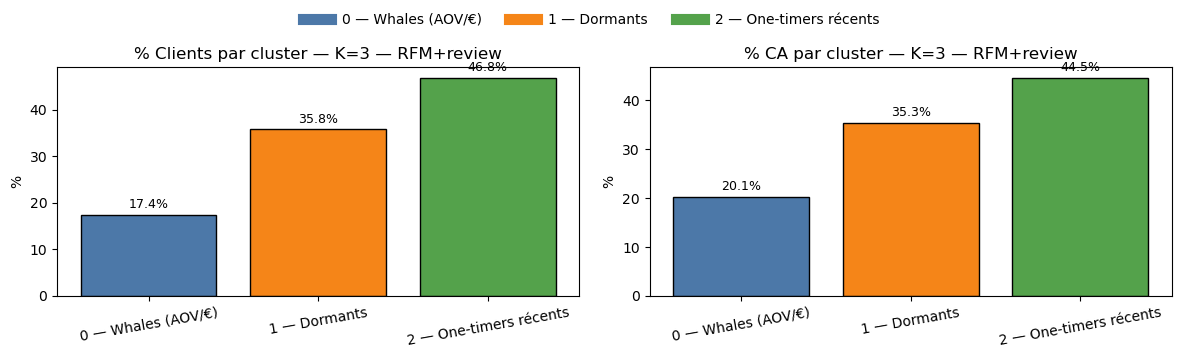

Saved -> outputs/kmeans_compare/RFM_review/radar_RFM+review_K3.png


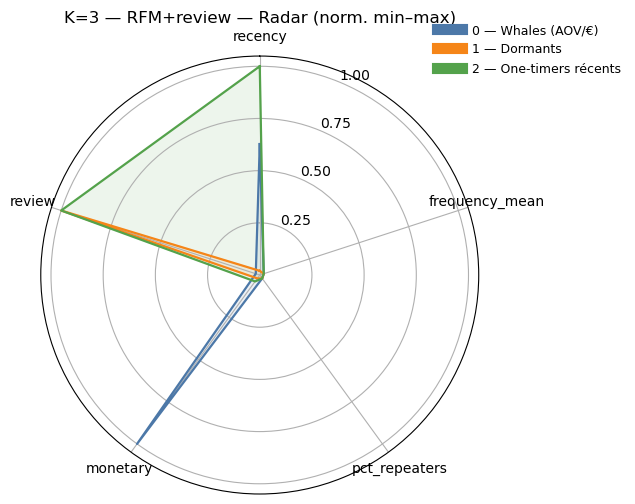

Saved -> outputs/kmeans_compare/RFM_review/bars_RFM+review_K4.png


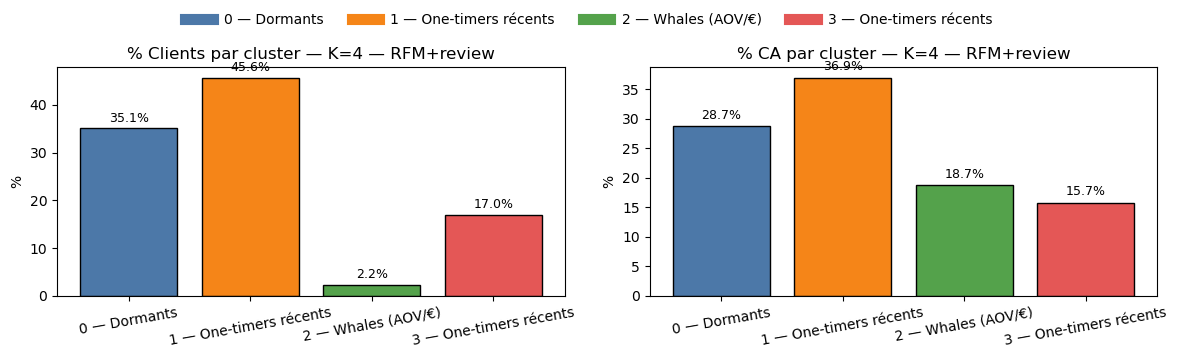

Saved -> outputs/kmeans_compare/RFM_review/radar_RFM+review_K4.png


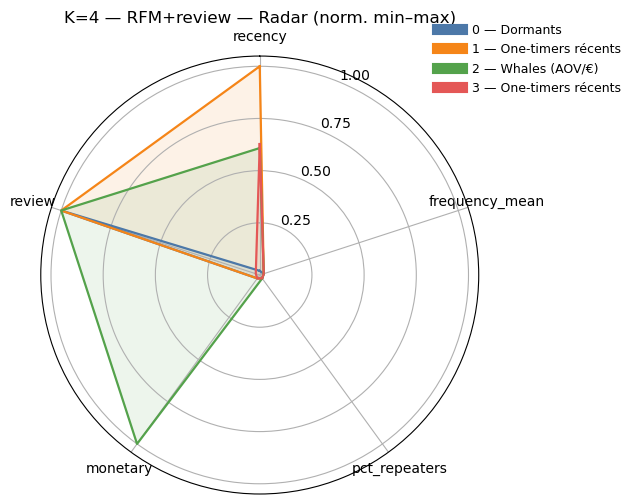

Saved -> outputs/kmeans_compare/RFM_review/bars_RFM+review_K5.png


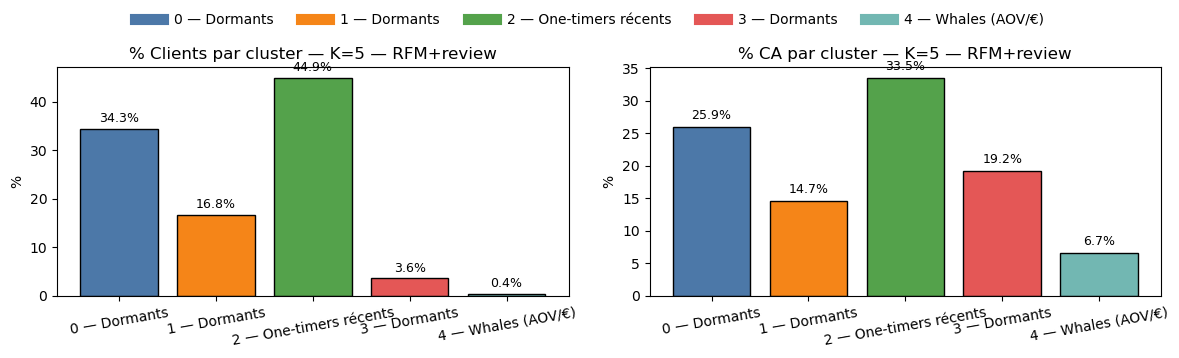

Saved -> outputs/kmeans_compare/RFM_review/radar_RFM+review_K5.png


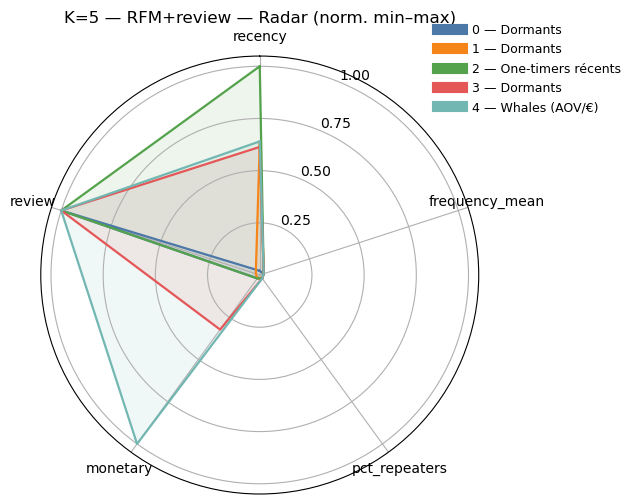


=== Variante: RFM+review+delay+AOV — features: ['recency_days', 'frequency', 'monetary', 'avg_review_score', 'delay_rate_ge3d', 'aov'] ===
Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/bars_RFM+review+delay+AOV_K3.png


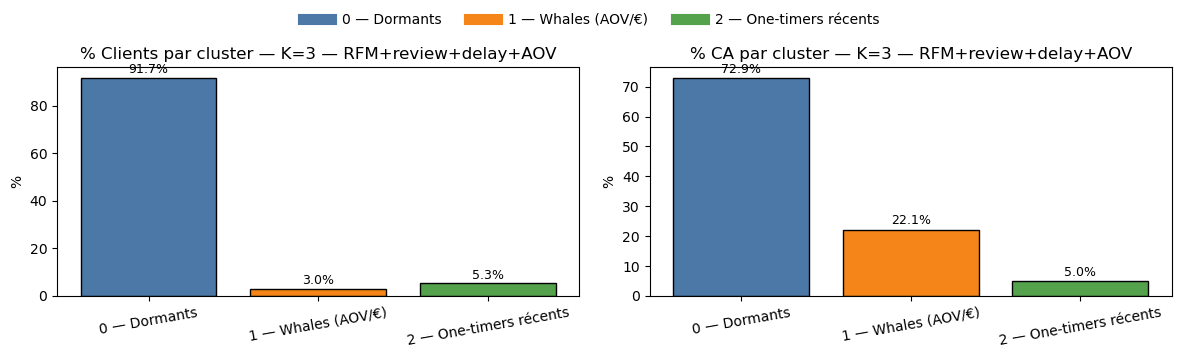

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/radar_RFM+review+delay+AOV_K3.png


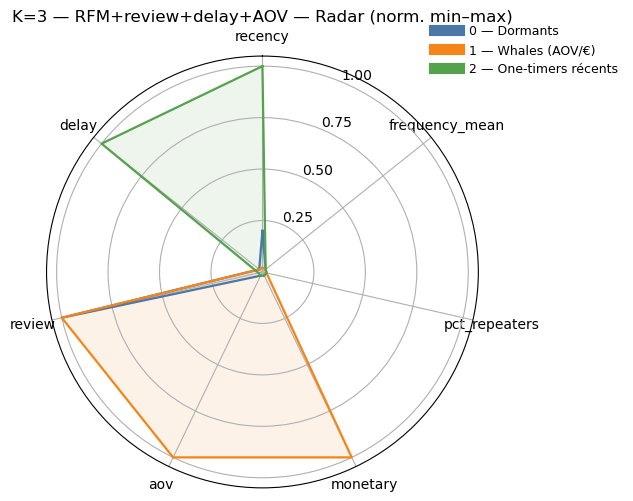

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/bars_RFM+review+delay+AOV_K4.png


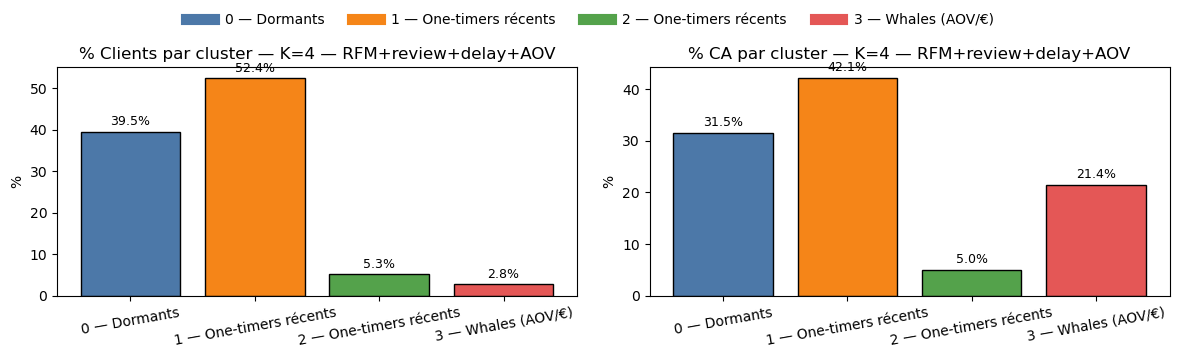

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/radar_RFM+review+delay+AOV_K4.png


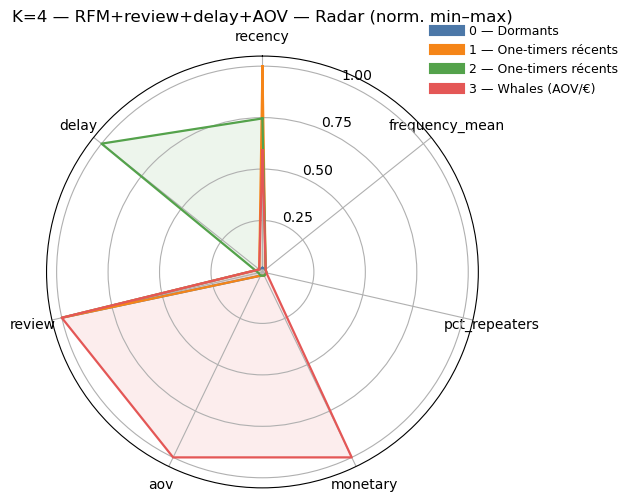

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/bars_RFM+review+delay+AOV_K5.png


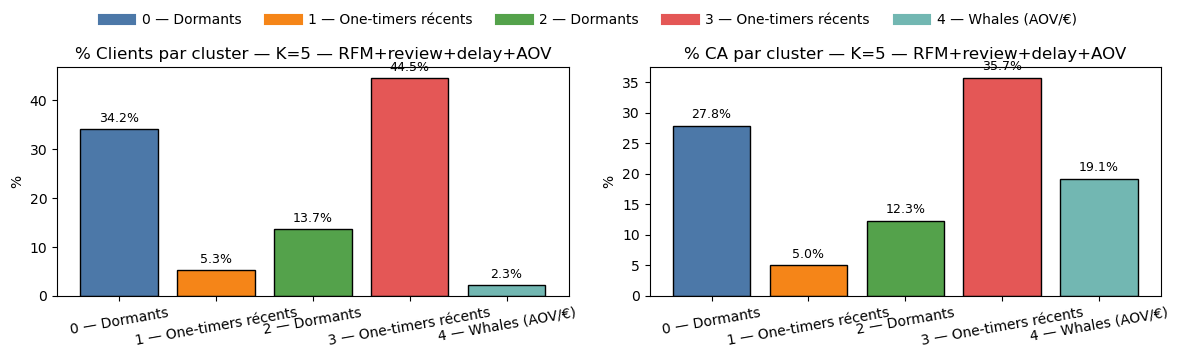

Saved -> outputs/kmeans_compare/RFM_review_delay_AOV/radar_RFM+review+delay+AOV_K5.png


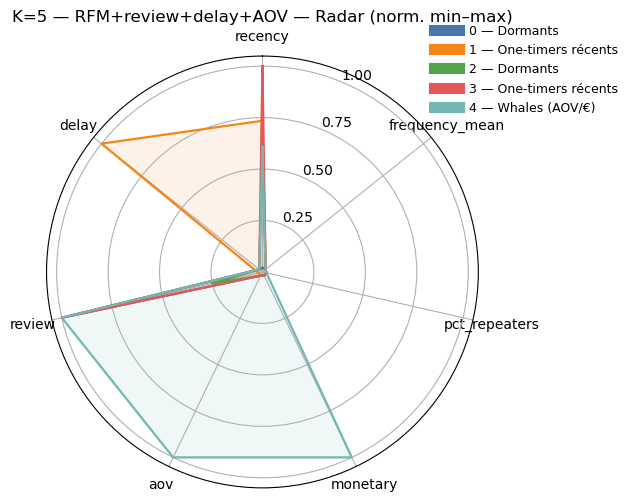


OK — images et CSV dans : outputs/kmeans_compare


In [1]:
# ============================================
# KMEANS – COMPARAISON K={3,4,5} + PLOTS COHÉRENTS
# ============================================
import os, sqlite3, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ---------- A) Chargement/Construction du dataset 'feat'
def build_feat_from_sqlite(db_path="olist.db"):
    orders_t, items_t, reviews_t = "orders", "order_items", "order_reviews"
    order_id_col, customer_id_col = "order_id", "customer_id"
    order_status_col  = "order_status"
    purchase_ts_col   = "order_purchase_timestamp"
    delivered_date_col = "order_delivered_customer_date"
    eta_date_col       = "order_estimated_delivery_date"
    price_col          = "price"
    review_score_col   = "review_score"

    with sqlite3.connect(db_path) as conn:
        ref_date = pd.read_sql_query(
            f"SELECT MAX({purchase_ts_col}) AS max_date FROM {orders_t};", conn
        )["max_date"].iloc[0]

        sql = f"""
        WITH base AS (
          SELECT 
            o.{customer_id_col} AS customer_id,
            o.{order_id_col}    AS order_id,
            DATE(o.{purchase_ts_col}) AS purchase_date,
            SUM(oi.{price_col}) AS order_revenue,
            CAST(julianday(o.{delivered_date_col}) - julianday(o.{eta_date_col}) AS INT) AS delay_days
          FROM {orders_t} o
          JOIN {items_t}  oi ON oi.{order_id_col} = o.{order_id_col}
          WHERE o.{order_status_col} = 'delivered'
          GROUP BY o.{customer_id_col}, o.{order_id_col}
        ),
        by_client AS (
          SELECT
            customer_id,
            MIN(purchase_date) AS first_order_date,
            MAX(purchase_date) AS last_order_date,
            COUNT(DISTINCT order_id) AS frequency,
            ROUND(SUM(order_revenue), 2) AS monetary,
            ROUND(AVG(CASE WHEN delay_days>=3 THEN 1.0 ELSE 0.0 END), 3) AS delay_rate_ge3d
          FROM base
          GROUP BY customer_id
        ),
        reviews AS (
          SELECT o.{customer_id_col} AS customer_id,
                 ROUND(AVG(r.{review_score_col}), 3) AS avg_review_score
          FROM {reviews_t} r
          JOIN {orders_t}  o ON o.{order_id_col} = r.{order_id_col}
          WHERE o.{order_status_col} = 'delivered'
          GROUP BY o.{customer_id_col}
        )
        SELECT 
          b.customer_id,
          CAST(julianday('{ref_date}') - julianday(b.last_order_date) AS INT) AS recency_days,
          b.frequency,
          b.monetary,
          ROUND(CASE WHEN b.frequency>0 THEN b.monetary*1.0/b.frequency ELSE NULL END, 2) AS aov,
          COALESCE(r.avg_review_score, 0.0) AS avg_review_score,
          COALESCE(b.delay_rate_ge3d, 0.0)  AS delay_rate_ge3d,
          b.last_order_date
        FROM by_client b
        LEFT JOIN reviews r USING(customer_id);
        """
        feat_local = pd.read_sql_query(sql, conn)

    feat_local = feat_local.fillna({'avg_review_score':0.0, 'delay_rate_ge3d':0.0})
    feat_local = feat_local[feat_local['frequency']>0].reset_index(drop=True)
    return feat_local

# Charge feat.csv si dispo, sinon reconstruit depuis SQLite
if os.path.exists("feat.csv"):
    feat = pd.read_csv("feat.csv")
else:
    feat = build_feat_from_sqlite("olist.db")

REQ = ['customer_id','recency_days','frequency','monetary','aov','avg_review_score','delay_rate_ge3d']
missing = [c for c in REQ if c not in feat.columns]
assert not missing, f"Colonnes manquantes dans feat: {missing}"

OUTDIR = "outputs/kmeans_compare"
os.makedirs(OUTDIR, exist_ok=True)

# ---------- B) Variantes de features + variables du radar
VARIANTS = {
    "RFM":                  ['recency_days','frequency','monetary'],
    "RFM+review":           ['recency_days','frequency','monetary','avg_review_score'],
    "RFM+review+delay+AOV": ['recency_days','frequency','monetary','avg_review_score','delay_rate_ge3d','aov'],
}
VARS_FOR_RADAR = {
    "RFM":                  ['recency','frequency_mean','pct_repeaters','monetary'],
    "RFM+review":           ['recency','frequency_mean','pct_repeaters','monetary','review'],
    "RFM+review+delay+AOV": ['recency','frequency_mean','pct_repeaters','monetary','aov','review','delay'],
}

# ---------- C) K-Means + profil enrichi
def kmeans_labels(X, k, random_state=42):
    km = KMeans(n_clusters=k, n_init=20, algorithm="elkan", random_state=random_state)
    return km.fit_predict(X)

def profile_by_cluster_enriched(df, labels):
    tmp = df.copy()
    tmp["cluster"] = labels
    g = tmp.groupby("cluster", as_index=False)

    prof = g.agg(
        n_clients    = ("customer_id","count"),
        recency_med  = ("recency_days","median"),
        freq_med     = ("frequency","median"),
        freq_mean    = ("frequency","mean"),
        monetary_med = ("monetary","median"),
        aov_med      = ("aov","median"),
        review_med   = ("avg_review_score","median"),
        delay_med    = ("delay_rate_ge3d","median"),
        monetary_sum = ("monetary","sum"),
    )

    # % repeaters
    tmp["is_repeater"] = (tmp["frequency"] >= 2).astype(float)
    rep = (tmp.groupby("cluster", as_index=False)["is_repeater"]
              .mean().rename(columns={"is_repeater":"pct_repeaters"}))
    prof = prof.merge(rep, on="cluster", how="left")

    # parts %
    tot_c = max(prof["n_clients"].sum(), 1)
    tot_r = max(prof["monetary_sum"].sum(), 1)
    prof["clients_share_%"] = 100 * prof["n_clients"]    / tot_c
    prof["revenue_share_%"] = 100 * prof["monetary_sum"] / tot_r

    # Personas simples (robustes)
    personas = []
    for _, r in prof.iterrows():
        if (r["aov_med"] > prof["aov_med"].quantile(0.85)) or (r["monetary_med"] > prof["monetary_med"].quantile(0.85)):
            personas.append("Whales (AOV/€)")
        elif (r["freq_med"] <= 1) and (r["recency_med"] >= prof["recency_med"].median()):
            personas.append("Dormants")
        elif r["freq_med"] <= 1:
            personas.append("One-timers récents")
        else:
            personas.append("Repeaters modérés")
    prof["persona"] = personas

    return prof.sort_values("cluster").reset_index(drop=True)

# ---------- D) Couleurs & légendes cohérentes
PALETTE = {
    "One-timers récents": "#4C78A8",  # bleu
    "Dormants":           "#F58518",  # orange
    "Whales (AOV/€)":     "#54A24B",  # vert
    "Repeaters modérés":  "#E45756",  # rouge
    "Standard":           "#72B7B2",  # teal (utilisé uniquement si présent)
}
CLUSTER_COLORS = [
    "#4C78A8", "#F58518", "#54A24B", "#E45756", "#72B7B2",
    "#B279A2", "#9E480E", "#1F9D8A", "#A0A0A0", "#FFC107"
]

def _lighten(hex_color, factor=0.35):
    r, g, b = mcolors.to_rgb(hex_color)
    r = 1 - (1 - r) * (1 - factor)
    g = 1 - (1 - g) * (1 - factor)
    b = 1 - (1 - b) * (1 - factor)
    return mcolors.to_hex((r, g, b))

def _labels_and_colors_by_persona(prof):
    prof = prof.sort_values("cluster").reset_index(drop=True)
    counts = {}
    xlabels, colors = [], []
    for _, row in prof.iterrows():
        p = row["persona"]
        counts[p] = counts.get(p, 0) + 1
        suffix = "" if counts[p] == 1 else f" ({chr(64+counts[p])})"  # (A),(B)…
        xlabels.append(f"{int(row['cluster'])} — {p}{suffix}")
        base = PALETTE.get(p, "#999999")
        col = base if counts[p] == 1 else _lighten(base, 0.55 if counts[p]==2 else 0.75)
        colors.append(col)

    personas_presentes = list(dict.fromkeys(prof["persona"]))
    handles = [plt.Line2D([0],[0], color=PALETTE[p], lw=8) for p in personas_presentes]
    legend_labels = personas_presentes
    return xlabels, colors, handles, legend_labels

def _labels_and_colors_by_cluster(prof):
    prof = prof.sort_values("cluster").reset_index(drop=True)
    xlabels = [f"{int(c)} — {p}" for c,p in zip(prof["cluster"], prof["persona"])]
    colors  = [CLUSTER_COLORS[int(c) % len(CLUSTER_COLORS)] for c in prof["cluster"]]
    handles = [plt.Line2D([0],[0], color=colors[i], lw=8) for i in range(len(colors))]
    legend_labels = xlabels
    return xlabels, colors, handles, legend_labels

# ---------- E) Plots (barres + radar) avec option de légende
def plot_bars_with_persona(prof, title, savepath=None, legend_mode="clusters"):
    prof = prof.sort_values("cluster").reset_index(drop=True)
    if legend_mode == "clusters":
        xlabels, cols, handles, legend_labels = _labels_and_colors_by_cluster(prof)
    else:
        xlabels, cols, handles, legend_labels = _labels_and_colors_by_persona(prof)

    fig, ax = plt.subplots(1, 2, figsize=(12, 3.6), sharey=False)

    ax[0].bar(xlabels, prof["clients_share_%"], color=cols, edgecolor="k")
    for i, v in enumerate(prof["clients_share_%"]):
        ax[0].text(i, v+0.8, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
    ax[0].set_title("% Clients par cluster — " + title)
    ax[0].set_ylabel("%"); ax[0].tick_params(axis='x', rotation=10)

    ax[1].bar(xlabels, prof["revenue_share_%"], color=cols, edgecolor="k")
    for i, v in enumerate(prof["revenue_share_%"]):
        ax[1].text(i, v+0.8, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
    ax[1].set_title("% CA par cluster — " + title)
    ax[1].set_ylabel("%"); ax[1].tick_params(axis='x', rotation=10)

    fig.legend(handles, legend_labels, loc="upper center",
               ncol=min(6, len(legend_labels)), frameon=False)

    plt.tight_layout(rect=[0,0,1,0.92])
    if savepath:
        plt.savefig(savepath, dpi=150)
        print("Saved ->", savepath)
    plt.show()

def plot_radar_enriched_consistent(prof, vars_for_radar, title, savepath=None, legend_mode="clusters"):
    prof = prof.sort_values("cluster").reset_index(drop=True)
    if legend_mode == "clusters":
        xlabels, cols, handles, legend_labels = _labels_and_colors_by_cluster(prof)
    else:
        xlabels, cols, handles, legend_labels = _labels_and_colors_by_persona(prof)

    # mapping “simple” -> série (recency inversée)
    data = {}
    for v in vars_for_radar:
        if v == 'recency':            data[v] = -prof['recency_med']
        elif v == 'frequency_mean':   data[v] =  prof['freq_mean']
        elif v == 'pct_repeaters':    data[v] =  prof['pct_repeaters']
        elif v == 'frequency_med':    data[v] =  prof['freq_med']
        elif v == 'monetary':         data[v] =  prof['monetary_med']
        elif v == 'aov':              data[v] =  prof['aov_med']
        elif v == 'review':           data[v] =  prof['review_med']
        elif v == 'delay':            data[v] =  prof['delay_med']
        else: raise ValueError(f"Var inconnue: {v}")
    df = pd.DataFrame(data)

    # min–max + plancher visuel
    mins, maxs = df.min(0), df.max(0)
    denom = (maxs - mins).replace(0, 1e-9)
    norm  = (df - mins) / denom
    norm  = norm.clip(lower=0.02)

    labels = list(norm.columns)
    N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig = plt.figure(figsize=(6.4, 6.2))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(np.pi/2); ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(labels)
    ax.set_yticks([0.25,0.5,0.75,1.0]); ax.set_yticklabels(["0.25","0.50","0.75","1.00"])

    for i, row in norm.iterrows():
        vals = row.tolist(); vals += vals[:1]
        ax.plot(angles, vals, linewidth=1.6, color=cols[i], label=xlabels[i])
        ax.fill(angles, vals, alpha=0.10, color=cols[i])

    ax.set_title(f"{title} — Radar (norm. min–max)")
    ax.legend(handles=handles, labels=legend_labels,
              loc='upper right', bbox_to_anchor=(1.35, 1.10), fontsize=9, frameon=False)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150)
        print("Saved ->", savepath)
    plt.show()

# ---------- F) Boucle principale : variantes × K (3,4,5)
LEGEND_MODE = "clusters"   # 'clusters' (exactement K entrées) ou 'personas'

for vname, cols in VARIANTS.items():
    print(f"\n=== Variante: {vname} — features: {cols} ===")
    subdir = os.path.join(OUTDIR, vname.replace('+','_')); os.makedirs(subdir, exist_ok=True)

    Xs = StandardScaler().fit_transform(feat[cols].values)
    for k in [3,4,5]:
        labels = kmeans_labels(Xs, k=k, random_state=42)
        prof = profile_by_cluster_enriched(feat, labels)

        title   = f"K={k} — {vname}"
        f_bars  = os.path.join(subdir, f"bars_{vname}_K{k}.png")
        f_radar = os.path.join(subdir, f"radar_{vname}_K{k}.png")

        plot_bars_with_persona(prof, title, savepath=f_bars, legend_mode=LEGEND_MODE)
        plot_radar_enriched_consistent(prof, VARS_FOR_RADAR[vname], title, savepath=f_radar, legend_mode=LEGEND_MODE)

        prof.to_csv(os.path.join(subdir, f"profile_{vname}_K{k}.csv"), index=False)

print("\nOK — images et CSV dans :", OUTDIR)

In [3]:
def audit_personas(prof):
    rows = []
    for _, r in prof.iterrows():
        name = r["persona"]
        ok = []

        # Règles attendues par persona
        if name.startswith("Dormants"):
            ok += [r["freq_med"] <= 1, r["recency_med"] >= prof["recency_med"].median()]
        if name.startswith("One-timers"):
            ok += [r["freq_med"] <= 1, r["recency_med"] < prof["recency_med"].median()]
        if name.startswith("Whales"):
            ok += [
                (r["aov_med"] >= prof["aov_med"].quantile(0.75)) or
                (r["monetary_med"] >= prof["monetary_med"].quantile(0.75))
            ]
        if name.startswith("Repeaters"):
            ok += [r["freq_med"] >= 2]

        score = sum(ok) / max(len(ok),1)
        verdict = "✅ OK" if score >= 0.67 else ("🟧 À revoir" if score >= 0.34 else "🟥 Incohérent")
        rows.append({
            "cluster": int(r["cluster"]),
            "persona": name,
            "check_score": round(score,2),
            "verdict": verdict,
            "recency_med": r["recency_med"],
            "freq_med": r["freq_med"],
            "aov_med": r["aov_med"],
            "monetary_med": r["monetary_med"]
        })
    return pd.DataFrame(rows).sort_values("cluster")

audit_df = audit_personas(prof)
print(audit_df.to_string(index=False))

 cluster            persona  check_score verdict  recency_med  freq_med  aov_med  monetary_med
       0           Dormants          1.0    ✅ OK        434.0       1.0    79.90         79.90
       1 One-timers récents          1.0    ✅ OK        240.0       1.0    89.99         89.99
       2           Dormants          1.0    ✅ OK        271.0       1.0    89.90         89.90
       3 One-timers récents          1.0    ✅ OK        170.0       1.0    80.00         80.00
       4     Whales (AOV/€)          1.0    ✅ OK        273.5       1.0   899.99        899.99


Barres “% Clients / % CA”
→ donnent le poids business de chaque segment (taille & contribution).

Radar
→ chaque polygone = un cluster, échelles normalisées 0–1 (comparatif, pas absolu).
→ j’ai inversé recency (plus récent = plus grand).
→ fort sur aov/monetary = “premium / whales”, fort sur recency & faible freq = “one-timers récents”, fort recency + freq ≥ 2 = “repeaters”, etc.

Deux clusters qui portent le même persona (ex. Dormants (A) et Dormants (B))
→ Normal avec K-Means : la “famille” Dormants peut être bimodale (ex. mêmes fréquences mais niveaux de dépenses/ancienneté différents). D’où les suffixes (A/B) pour lever toute ambiguïté visuelle.

Ce que montrent les résultats
1) RFM seul (K=3 → K=5)

K=3

Clients : ~55% One-timers récents, ~42% Dormants, ~3% Whales.

CA : ~45% One-timers récents, ~33% Dormants, ~22% Whales.

Lecture : simple et propre, mais Whales et Repeaters se retrouvent compressés (peu de nuances).

K=4

Deux sous-groupes proches (Dormants A/B ou One-timers A/B) apparaissent.

Radar : séparation un peu artificielle (même forme, niveaux proches).

Lecture : tu gagnes une “barre” mais pas forcément une histoire métier en plus.

K=5

On coupe encore un groupe “froid” en deux ; Whales restent très petits mais leur CA reste fort.

Lecture : sur-segmentation côté “froids”, peu d’info actionnable supplémentaire.

Bilan RFM seul : solide pour la base, mais perd du pouvoir explicatif marketing (satisfaction/délais absents) et crée des doublons “froids” dès K≥4.

2) RFM + Review

K=3 / K=4 / K=5

L’axe review met bien en évidence que les Whales tirent le plus haut niveau de satisfaction.

Les barres %CA restent proches de RFM seul (structure business conservée).

Gain : un critère de qualité exploitable (NPS-like) pour les plans d’actions.

Limite : sans delay ni aov, les Whales sont parfois dilués dans de “gros paniers” non distincts.

Bilan RFM+review : mieux que RFM pour la lecture “qualité client”, mais encore trop léger pour isoler proprement la valeur.

3) RFM + Review + Delay + AOV (ta variante “RFM+3”)

K=3

Très lisible mais trop compact : Whales et un sous-groupe one-timers restent collés.

-------------------------------K=4 (le plus intéressant)----------------------------------------

Répartition clients : ~40% Dormants, ~50% One-timers récents (A + B), ~2–3% Whales.

Répartition CA : ~42% One-timers récents, ~31% Dormants, ~21% Whales (très rentable malgré la petite taille), ~5% One-timers B.

Radar :

Whales = AOV & monetary au max, reviews élevés, delay bas → segment VIP propre.

One-timers A = très récents, faible freq, delay bas → acquisition / 1er achat.

One-timers B = profil proche mais moins récent ou plus sensibles au délai → risque d’attrition à relancer.

Dormants = récence haute, freq 1, valeur faible → nurture / réactivation.

Lecture : 4 rôles marketing clairs, pas de doublon incohérent, et signaux opérationnels (review/delay/AOV) pour piloter des campagnes différentes.

--------------------------------------------------------------------------------------------------------------------

K=5

On re-scinde encore les “froids” (Dormants A/B). Les radars restent look-alike, et le gain d’actionnabilité est faible.

Lecture : sur-segmentation des inactifs, pas de nouveau persona utile.

Bilan RFM+3 : c’est la meilleure variante pour raconter une histoire métier cohérente ET actionnable :

elle isole un segment VIP (peu de clients, beaucoup de CA),

elle distingue acquisition récente vs presque perdus,

elle matérialise des leviers (review/delay) pour les plans d’actions.

Pourquoi nous voyons parfois “deux Dormants” (ou deux One-timers)

K-Means minimise la variance au sein des groupes. Si la zone “froide” (faible freq/monetary, forte recency) est très large, l’algorithme la coupe souvent en deux poches (A/B).

Ce n’est pas une erreur : c’est une sur-segmentation possible quand K augmente, mais qui n’apporte pas toujours de stratégie marketing distincte.

La légende “(A)/(B)” gère proprement la cohérence couleur/label — à garder.

Reco finale (objective & orientée business)

Modèle recommandé : KMeans avec K = 4 sur la variante RFM + review + delay + AOV (RFM+3).
Pourquoi :

Segments utiles & lisibles

Whales (AOV/€) : 2–3% clients, ~20% CA → programme VIP, priorité logistique (delay bas), recos premium.

One-timers récents (A) : ~40–50% clients, ~40% CA → onboarding & 2ᵉ achat (bundles, email J+X, coupons).

One-timers récents (B) : petit segment à haut potentiel mais + sensibles au delay ou + ancien → relance, incitations logistiques.

Dormants : ~35–40% clients, ~30% CA → réactivation (email Win-Back, promos, contenus “retour”).

Actionnabilité immédiate via review & delay (leviers non financiers).

Stabilité/Parcimonie : K=3 perd des nuances de valeur, K=5 sur-segmente les “froids”. K=4 = bon compromis.

Cohérence avec tes précédents diagnostics (tes ARI/stabilité étaient OK avec K=4, et le split métier est convaincant).

Deux mini-contrôles à faire (vite) pour sécuriser la soutenance

Sanity check de stabilité (tu l’as déjà en grande partie)

Standardisation identique, même random_state=42, mêmes features exactes → re-lancer 2–3 fois pour vérifier que la composition ne bouge pas.

Qualité interne (optionnel mais rassurant)

Affiche inertia (elbow) & silhouette pour K=3..6 sur la variante RFM+3. Même si ce n’est pas le critère décisif, ça montrera que K=4 n’est pas aberrant côté métriques.

Résumé one-pager pour Olist (à réutiliser tel quel)

Choix : K-Means, K=4, variables RFM + avis + délai + AOV.

Raison : 4 segments distincts & actionnables qui couvrent 100% du portefeuille et expliquent le CA :

Whales (AOV/€) — très forte valeur, faible volume (2–3%), ~20% du CA → traiter en VIP (qualité & rapidité).

One-timers récents (A) — acquisition à convertir en repeaters → onboarding, bundles, offres 2ᵉ achat.

One-timers récents (B) — proches d’A mais plus sensibles au délai/moins récents → relance + gestes logistiques.

Dormants — forte base à réactiver → email Win-Back, promos retour, contenus.

Impact : ciblage clair par levier (review/delay), meilleure conversion 1→2, protection du CA VIP, réactivation des dormants.

Robustesse : plus stable et plus lisible que K=3 (trop agrégé) et que K=5 (sur-segmentation des “froids”).

In [2]:
import os, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

OUTDIR = "outputs/kmeans_compare"
os.makedirs(OUTDIR, exist_ok=True)

# ---- variantes d'entrée (comme ton notebook)
VARIANTS = {
    "RFM":                  ['recency_days','frequency','monetary'],
    "RFM+review":           ['recency_days','frequency','monetary','avg_review_score'],
    "RFM+review+delay+AOV": ['recency_days','frequency','monetary','avg_review_score','delay_rate_ge3d','aov'],
}
K_LIST = [3,4,5]

# ---- petit helper KMeans
def kmeans_labels(X, k, random_state=42):
    km = KMeans(n_clusters=k, n_init=20, algorithm="elkan", random_state=random_state)
    return km.fit_predict(X)

# ---- profil enrichi + personas (identique à ta logique)
def profile_by_cluster_enriched(df, labels):
    tmp = df.copy()
    tmp["cluster"] = labels
    g = tmp.groupby("cluster", as_index=False)

    prof = g.agg(
        n_clients    = ("customer_id","count"),
        recency_med  = ("recency_days","median"),
        freq_med     = ("frequency","median"),
        freq_mean    = ("frequency","mean"),
        monetary_med = ("monetary","median"),
        aov_med      = ("aov","median"),
        review_med   = ("avg_review_score","median"),
        delay_med    = ("delay_rate_ge3d","median"),
        monetary_sum = ("monetary","sum"),
    )

    tmp["is_repeater"] = (tmp["frequency"] >= 2).astype(float)
    rep = (tmp.groupby("cluster", as_index=False)["is_repeater"]
              .mean().rename(columns={"is_repeater":"pct_repeaters"}))
    prof = prof.merge(rep, on="cluster", how="left")

    tot_c = max(prof["n_clients"].sum(), 1)
    tot_r = max(prof["monetary_sum"].sum(), 1)
    prof["clients_share_%"] = 100 * prof["n_clients"]    / tot_c
    prof["revenue_share_%"] = 100 * prof["monetary_sum"] / tot_r

    # Personas simples & stables
    personas = []
    for _, r in prof.iterrows():
        if (r["aov_med"] > prof["aov_med"].quantile(0.85)) or (r["monetary_med"] > prof["monetary_med"].quantile(0.85)):
            personas.append("Whales (AOV/€)")
        elif (r["freq_med"] <= 1) and (r["recency_med"] >= prof["recency_med"].median()):
            personas.append("Dormants")
        elif r["freq_med"] <= 1:
            personas.append("One-timers récents")
        else:
            personas.append("Repeaters modérés")
    prof["persona"] = personas

    return prof.sort_values("cluster").reset_index(drop=True)

# ---- boucle variantes × K → grand tableau
rows = []
for vname, cols in VARIANTS.items():
    Xs = StandardScaler().fit_transform(feat[cols].values)
    for k in K_LIST:
        labels = kmeans_labels(Xs, k=k, random_state=42)
        prof = profile_by_cluster_enriched(feat, labels)

        # ajoute des colonnes d'identification
        prof.insert(0, "variant", vname)
        prof.insert(1, "K", k)

        # on garde un sous-ensemble lisible + indicateurs clés
        keep = ["variant","K","cluster","persona",
                "n_clients","clients_share_%","revenue_share_%",
                "recency_med","freq_med","freq_mean",
                "monetary_med","aov_med","review_med","delay_med","pct_repeaters"]
        rows.append(prof[keep])

summary = pd.concat(rows, ignore_index=True)

# ordonnancement pour lecture
summary = summary.sort_values(["variant","K","cluster"]).reset_index(drop=True)

# exports
csv_path   = os.path.join(OUTDIR, "summary_by_variant_k.csv")
xlsx_path  = os.path.join(OUTDIR, "summary_by_variant_k.xlsx")
summary.to_csv(csv_path, index=False)

with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as writer:
    for v in VARIANTS.keys():
        summary.loc[summary["variant"]==v].to_excel(writer, sheet_name=v, index=False)

print("✅ Exports créés :")
print(" -", csv_path)
print(" -", xlsx_path)

# petit aperçu “board-ready” (par variante/K)
display(
    summary.groupby(["variant","K","persona"])
           .agg(n_clusters=("cluster","nunique"),
                clients_share_total=("% clients", lambda s: None))  # placeholder pour éviter erreur
)

# Aperçu simple trié par %CA décroissant
display(
    summary.sort_values(["variant","K","revenue_share_%"], ascending=[True,True,False])
           .groupby(["variant","K"]).head(10).reset_index(drop=True)
)

ModuleNotFoundError: No module named 'xlsxwriter'